In [1]:
import pandas as pd
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
from scipy import stats

In [2]:
borders = pd.read_csv('regions.csv', sep = ';', header =0)

In [3]:
borders.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [4]:
dt = pd.read_csv('yellow_tripdata_2016-05.csv', sep = ',', header = 0)

In [5]:
dt.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


#### Steps From Previous Week: data cleaning + pickup time transformation

In [6]:
long_borders = [borders.west.min().tolist(), borders.east.max().tolist()]
lat_borders  = [borders.south.min().tolist(), borders.north.max().tolist()]

#simple approach under assumption that NYC is actually a square
dt['is_in_NYC'] = 0

dt.loc[(dt.pickup_longitude >= long_borders[0])
            & (dt.pickup_longitude <= long_borders[1])
            & (dt.pickup_latitude >= lat_borders[0])
            & (dt.pickup_latitude <= lat_borders[1])
        ,'is_in_NYC'] = 1

In [7]:
#Отбросьте минуты и секунды во времени начала поездки.
dt['tpep_pickup_datetime'] = pd.to_datetime(dt['tpep_pickup_datetime'])
dt['tpep_dropoff_datetime'] = pd.to_datetime(dt['tpep_dropoff_datetime'])

def hours_only(ts):
    t = pd.DataFrame({'Year': ts.dt.year
                  ,'Month':ts.dt.month
                  ,'Day':ts.dt.day
                  ,'Hour':ts.dt.hour })
    return(pd.to_datetime(t))

dt['tpep_pickup_datetime_short'] = hours_only(dt['tpep_pickup_datetime'])
dt['tpep_dropoff_datetime_short'] = hours_only(dt['tpep_dropoff_datetime'])

In [8]:
### cleaning
dt_cl = dt.loc[(dt.is_in_NYC == 1)
                        & (dt.trip_distance > 0)
                        & (dt.passenger_count > 0)
                        & ~(dt.tpep_pickup_datetime == dt.tpep_dropoff_datetime)]

In [9]:
print 'Cleaned shape: ', dt_cl.shape
print 'Initial shape: ', dt.shape
print 'Remaining: ', 1.0*dt_cl.shape[0]/dt.shape[0]

Cleaned shape:  (11626521, 22)
Initial shape:  (11836853, 22)
Remaining:  0.982230750014


## Current weeks tasks

Useful links

http://blog.kaggle.com/2016/11/30/seventeen-ways-to-map-data-in-kaggle-kernels/

http://matplotlib.org/basemap/, https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb

https://github.com/pbugnion/gmaps

https://github.com/jupyter-widgets/ipyleaflet, https://github.com/jupyter-widgets/ipyleaflet/blob/master/examples/MapContainer.ipynb

https://github.com/python-visualization/folium

### 1.

Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [10]:
# FROM PREVIOUS WEEK
# I do not invent something: I take borders from model file,
# the requirement is to have the same id but not to create id that are the same =___=
long_borders = list(set(borders.west.tolist() + borders.east.tolist()))
lat_borders = list(set(borders.south.tolist() + borders.north.tolist()))

long_borders.sort()
lat_borders.sort()

In [11]:
def counts_per_region(x,y):
    tmp = stats.binned_statistic_2d(x, y
                          , None, 'count'
                          , bins=[long_borders,lat_borders]
                          , expand_binnumbers=True)
    return(tmp.statistic.reshape((1, 2500)))

In [12]:
rez_time = []
rez_count = []
rez_id = range(1,2501,1)

x = dt_cl['pickup_longitude']
y = dt_cl['pickup_latitude']
rez = counts_per_region(x,y).tolist()[0]
rez_count = rez_count + rez

stats.binned_statistic_2d(x, y
                          , None, 'count'
                          , bins=[long_borders,lat_borders]
                          , expand_binnumbers=True)

BinnedStatistic2dResult(statistic=array([[0., 0., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), x_edge=array([-74.25559  , -74.2444784, -74.2333668, -74.2222552, -74.2111436,
       -74.200032 , -74.1889204, -74.1778088, -74.1666972, -74.1555856,
       -74.144474 , -74.1333624, -74.1222508, -74.1111392, -74.1000276,
       -74.088916 , -74.0778044, -74.0666928, -74.0555812, -74.0444696,
       -74.033358 , -74.0222464, -74.0111348, -74.0000232, -73.9889116,
       -73.9778   , -73.9666884, -73.9555768, -73.9444652, -73.9333536,
       -73.922242 , -73.9111304, -73.9000188, -73.8889072, -73.8777956,
       -73.866684 , -73.8555724, -73.8444608, -73.8333492, -73.8222376,
       -73.811126 , -73.8000144, -73.7889028, -73.7777912, -73.7666796,
       -73.755568 , -73.7444564, -73.7333448, -73.7222332, -73.711121

In [13]:
counts_data = pd.DataFrame({'Square_id': rez_id
                            ,'Counts': rez_count})
counts_data.head(20)

,Counts,Square_id
0,0.0,1
1,0.0,2
2,0.0,3
3,0.0,4
4,0.0,5
5,0.0,6
6,0.0,7
7,0.0,8
8,0.0,9
9,0.0,10


In [14]:
counts_data.loc[counts_data.Square_id == 1230].head()

,Counts,Square_id
1229,476106.0,1230


In [15]:
borders.loc[borders.region == 1230]

,region,west,east,south,north
1229,1230,-73.988912,-73.9778,40.739378,40.747766


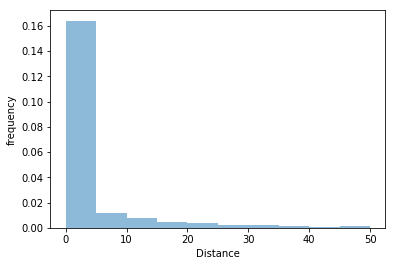

In [16]:
plt.figure()

plt.hist(counts_data.Counts
                 , normed=True
                 #,label= patterns[i]
                 , range = (0,50)
                 , alpha = 0.5)

plt.ylabel('frequency')
plt.xlabel('Distance')
#plt.legend()
plt.show()

In [17]:
print counts_data['Counts'].quantile(q = [0.01,0.025,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.95, 0.975, 0.99, 1])

0.010         0.000
0.025         0.000
0.050         0.000
0.100         0.000
0.200         0.000
0.300         0.000
0.400         0.000
0.500         0.000
0.600         1.000
0.700         4.000
0.800        18.000
0.900       167.500
0.950      1839.250
0.975     16216.025
0.990    172175.930
1.000    638799.000
Name: Counts, dtype: float64


In [18]:
print 'Number Of Cellc With No Drive:', counts_data.loc[counts_data.Counts == 0].shape[0]
print 'Total number of cells:', counts_data.shape[0]
print '% of Cells With no Drive:', (1.0*counts_data.loc[counts_data.Counts == 0].shape[0])/counts_data.shape[0]

Number Of Cellc With No Drive: 1283
Total number of cells: 2500
% of Cells With no Drive: 0.5132


### 2.

Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
%matplotlib inline

In [20]:
print 'long', min(long_borders), max(long_borders)
print 'lat', min(lat_borders), max(lat_borders)


long -74.25559 -73.70001
lat 40.49612 40.91553


C:\ProgramData\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
C:\ProgramData\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch


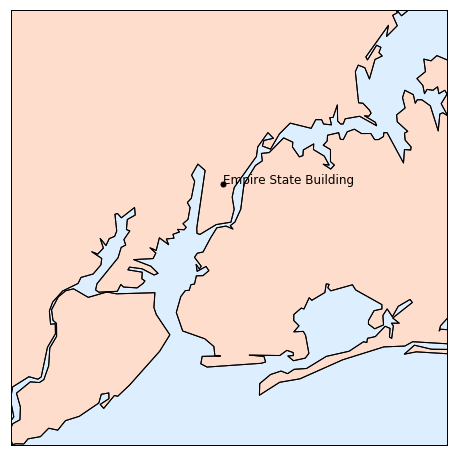

In [21]:
#source: https://rabernat.github.io/research_computing/intro-to-basemap.html
fig = plt.figure(figsize=(12, 8) )
m = Basemap(projection='merc',llcrnrlat=40.49612, urcrnrlat=40.91553,
            llcrnrlon=-74.25559, urcrnrlon=-73.70001,resolution='h')
m.drawcoastlines()
m.fillcontinents(color='tan',lake_color='lightblue')

m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

x, y = m(-73.9857, 40.7484)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Empire State Building', fontsize=12);

### 3.

Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [22]:
x = dt_cl['pickup_longitude']
y = dt_cl['pickup_latitude']
data = stats.binned_statistic_2d(x, y
                          , None, 'count'
                          , bins=[long_borders,lat_borders]
                          , expand_binnumbers=True)
xx, yy = np.meshgrid(long_borders,lat_borders)

C:\ProgramData\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\ProgramData\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


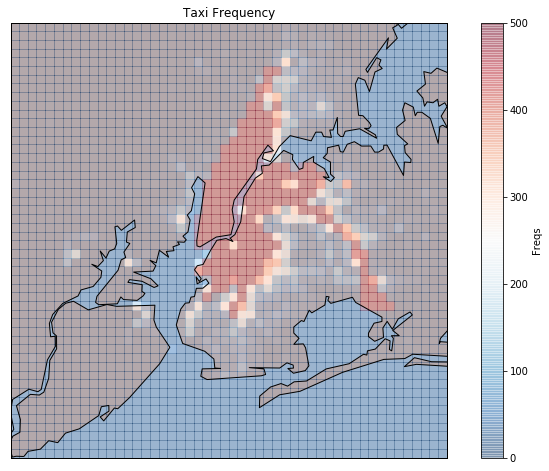

In [23]:
fig = plt.figure(figsize=(12, 8) )
m = Basemap(projection='merc'
            ,llcrnrlat=40.49612, urcrnrlat=40.91553,llcrnrlon=-74.25559, urcrnrlon=-73.70001
            ,resolution='h')

m.drawrivers(color='#0000ff', zorder = 1)
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF', zorder = 0)
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

m.pcolormesh(xx, yy, data.statistic.transpose(), latlon=True, cmap='RdBu_r', alpha = 0.3)
plt.clim(0, 500)
#m.drawcoastlines(color='lightgray')

plt.title('Taxi Frequency')
plt.colorbar(label='Freqs')

### 4

Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [24]:
#https://automating-gis-processes.github.io/2017/lessons/L5/interactive-map-folium.html
#http://folium.readthedocs.io/en/latest/quickstart.html
#http://folium.readthedocs.io/en/latest/installing.html
import folium

In [25]:
m = folium.Map(location=[40.730610, -73.935242],
                zoom_start=12, control_scale=True, prefer_canvas=True
                ,height = '70%', width = '70%')

# Filepath to the output
outfp = "base_map2.html"
# Save the map
m.save(outfp)

folium.Marker([40.6892,-74.0445], popup='Liberty State').add_to(m)

m

### 5

Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны

In [26]:
## partially from previous week
def counts_per_region(x,y):
    tmp = stats.binned_statistic_2d(x, y
                          , None, 'count'
                          , bins=[long_borders,lat_borders]
                          , expand_binnumbers=True)
    return(tmp.statistic.reshape((1, 2500)))

In [27]:
time_list = dt['tpep_pickup_datetime_short'].unique()

In [28]:
rez_time = []
rez_count = []
rez_id = range(1,2501,1)*len(time_list)
for t in time_list:
    x = dt_cl.loc[dt_cl.tpep_pickup_datetime_short == t, 'pickup_longitude']
    y = dt_cl.loc[dt_cl.tpep_pickup_datetime_short == t, 'pickup_latitude']
    rez = counts_per_region(x,y).tolist()[0]
    rez_count = rez_count + rez
    rez_time = rez_time + [t]*2500

In [29]:
counts_data = pd.DataFrame({'Time': rez_time
                             ,'Square_id': rez_id
                             ,'Counts': rez_count})
counts_data.loc[counts_data.Square_id == 1230].head() #check 

,Counts,Square_id,Time
1229,1258.0,1230,2016-05-01 00:00:00
3729,1191.0,1230,2016-05-04 22:00:00
6229,889.0,1230,2016-05-04 23:00:00
8729,544.0,1230,2016-05-05 00:00:00
11229,367.0,1230,2016-05-05 01:00:00


In [30]:
desc_per_square = pd.pivot_table(counts_data, values='Counts', index=['Square_id'],
                  columns=None, aggfunc=[np.sum, np.mean])

In [31]:
desc_per_square.shape

(2500, 2)

In [32]:
desc_per_square.head()

,sum,mean
,Counts,Counts
Square_id,,
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


In [33]:
#http://folium.readthedocs.io/en/latest/installing.html
from folium.plugins import HeatMap
import pysal as ps

In [34]:
#http://geopandas.org/install.html
import geopandas as gpd
from shapely.geometry import Polygon

In [35]:
borders['Avg'] = pd.Series(desc_per_square.as_matrix()[:,1], index=borders.index)
borders['Sum'] = pd.Series(desc_per_square.as_matrix()[:,0], index=borders.index)

In [36]:
borders.head(7)

,region,west,east,south,north,Avg,Sum
0,1,-74.25559,-74.244478,40.496120,40.504508,0.0,0.0
1,2,-74.25559,-74.244478,40.504508,40.512896,0.0,0.0
2,3,-74.25559,-74.244478,40.512896,40.521285,0.0,0.0
3,4,-74.25559,-74.244478,40.521285,40.529673,0.0,0.0
4,5,-74.25559,-74.244478,40.529673,40.538061,0.0,0.0
5,6,-74.25559,-74.244478,40.538061,40.546449,0.0,0.0
6,7,-74.25559,-74.244478,40.546449,40.554837,0.0,0.0


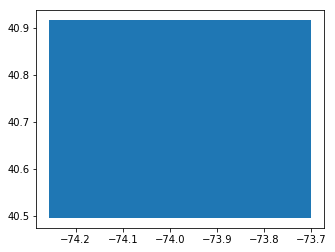

In [37]:
#http://geopandas.org/geometric_manipulations.html#constructive-methods
tmp = []
for i in range(50*50):
    tmp.append(Polygon([(borders.loc[borders.region == i+1, 'west'].tolist()[0]
                         ,borders.loc[borders.region == i+1, 'north'].tolist()[0])
                        ,(borders.loc[borders.region == i+1, 'east'].tolist()[0]
                          ,borders.loc[borders.region == i+1, 'north'].tolist()[0])     
                        ,(borders.loc[borders.region == i+1, 'east'].tolist()[0]
                          ,borders.loc[borders.region == i+1, 'south'].tolist()[0])
                        ,(borders.loc[borders.region == i+1, 'west'].tolist()[0]
                          ,borders.loc[borders.region == i+1, 'south'].tolist()[0])
                        ]))
g = gpd.GeoSeries(tmp)
g.plot()

In [38]:
newdata = gpd.GeoDataFrame()
newdata['geometry'] = g
newdata['idd'] = borders['region'].values
newdata['c'] = borders['Avg'].values

In [39]:
newdata.head()

,geometry,idd,c
0,"POLYGON ((-74.25559 40.5045082, -74.2444784000...",1,0.0
1,"POLYGON ((-74.25559 40.5128964, -74.2444784000...",2,0.0
2,"POLYGON ((-74.25559 40.5212846, -74.2444784000...",3,0.0
3,"POLYGON ((-74.25559 40.52967279999999, -74.244...",4,0.0
4,"POLYGON ((-74.25559 40.538061, -74.24447840000...",5,0.0


In [40]:
#newdata.to_json()

In [41]:
m = folium.Map(location=[40.730610, -73.935242],
                zoom_start=12, control_scale=True, prefer_canvas=True
                ,height = '70%', width = '70%')

#http://andrewgaidus.com/leaflet_webmaps_python/
m.choropleth(geo_data = newdata.to_json()
             , data = newdata
             , columns = ['idd', 'c']
             , key_on = 'feature.properties.idd'
             , fill_color = 'YlOrRd'
             , fill_opacity=0.4
             , line_color='lightgreay'

            )
m

### 6

Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [42]:
popular = newdata.loc[newdata.c > 5]
popular.shape

(102, 3)

In [43]:
m = folium.Map(location=[40.730610, -73.935242],
                zoom_start=12, control_scale=True, prefer_canvas=True
                ,height = '70%', width = '70%')

#http://andrewgaidus.com/leaflet_webmaps_python/
m.choropleth(geo_data = popular.to_json()
             , data = popular
             , columns = ['idd', 'c']
             , key_on = 'feature.properties.idd'
             , fill_color = 'YlOrRd'
             , fill_opacity=0.4
             , line_color='lightgreay'

            )
m